# TaiChung DE PV Forecast with SVR

Data source : TaiChung DE PV plant, CWB WUQI weather.

Period : 2016/01/01-2017/12/31.

Frequency: 1 hour.

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Reading the dataset

In [2]:
# quick look data
data = pd.read_csv('data\Power_High_degree.csv', parse_dates=['Date'], index_col='Date')
print(data.head(12))
print(data.describe().transpose())

                     power(KWH)  SunShine  GloblRad  Solar Irradiance
Date                                                                 
2016-01-01 01:00:00         0.0       0.0      0.00          0.000000
2016-01-01 02:00:00         0.0       0.0      0.00          0.000000
2016-01-01 03:00:00         0.0       0.0      0.00          0.000000
2016-01-01 04:00:00         0.0       0.0      0.00          0.000000
2016-01-01 05:00:00         0.0       0.0      0.00          0.000000
2016-01-01 06:00:00         0.0       0.0      0.00          4.164694
2016-01-01 07:00:00         0.0       0.0      0.00        107.933226
2016-01-01 08:00:00       146.0       0.7      0.30        305.363132
2016-01-01 09:00:00       444.0       1.0      0.89        477.315428
2016-01-01 10:00:00       680.0       1.0      1.52        621.637047
2016-01-01 11:00:00       892.0       1.0      1.32        664.687495
2016-01-01 12:00:00       932.0       1.0      2.30        623.537282
                    

# Visualizing data

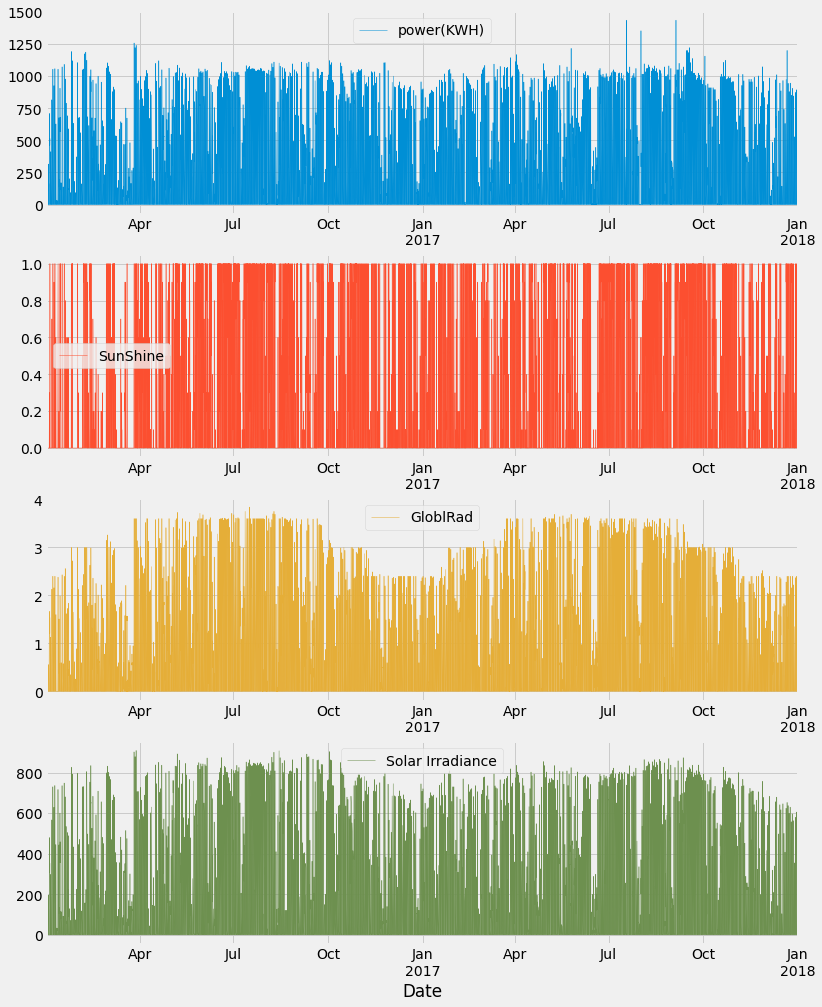

In [3]:
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(4, 1), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

# Feature

According to SARIMA(0,1,0)(0,1,1,24) result: choose lag 1, 24.

In [4]:
# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        df[col+'_Lag_' + str(i)] = df[col].shift(i)
    return df

for col in data.columns:
    data_lag=create_lags(data, col,[1,24])

data_lag.dropna(inplace=True)

Generate hour feature.

In [5]:
data_lag['Hour'] = data_lag.index.hour

Choose target and feature.

In [6]:
# choose day time
daytime_idx = (6<= data_lag.index.hour) & (data_lag.index.hour<= 18)
# choose feature and target
Target = data_lag.loc[daytime_idx, 'power(KWH)']
Feature = data_lag.loc[daytime_idx,'power(KWH)_Lag_1':]

Generate morning and afternoon feature.

In [7]:
# One of N encoding.
def morning_afternoon(hour):
    if 6<= hour <=12:
        return 'morning'
    else:
        return 'afternoon'

Feature['period'] = Feature['Hour'].apply(morning_afternoon)
Feature = Feature.join(pd.get_dummies(Feature['period']))
Feature.drop(columns=['period'], inplace=True)
print(Feature.head(1))

                     power(KWH)_Lag_1  power(KWH)_Lag_24  SunShine_Lag_1  \
Date                                                                       
2016-01-02 06:00:00               0.0                0.0             0.0   

                     SunShine_Lag_24  GloblRad_Lag_1  GloblRad_Lag_24  \
Date                                                                    
2016-01-02 06:00:00              0.0             0.0              0.0   

                     Solar Irradiance_Lag_1  Solar Irradiance_Lag_24  Hour  \
Date                                                                         
2016-01-02 06:00:00                     0.0                 4.164694     6   

                     afternoon  morning  
Date                                     
2016-01-02 06:00:00          0        1  


Choose last 4 month to validation.

In [8]:
# Split train and test data
X_train, X_test, y_train, y_test = Feature[:'2017-08-31'], Feature['2017-09-01':], Target[:'2017-08-31'], Target['2017-09-01':]

# Tune Parameters

SVR 

$$\underset {b,w,\epsilon}{min} \frac{1}{2}w^{T}{w} +C \sum^{N}_{n=1} \epsilon_{n}$$

s.t. $$y_{n} - w^{T}x_{n} - b < \epsilon_{n}$$
$$\epsilon_{n} \geq 0 $$

C(cost) is not easy to optimizer, so eave one out validation.

Time seriese can't cross validation.

You can't use furture to predict past.


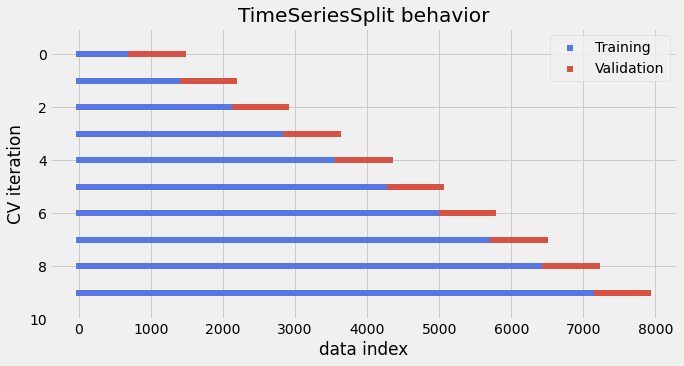

In [9]:
cv = TimeSeriesSplit(n_splits=10)
fig, ax = plt.subplots(figsize=(10, 5))
for ii, (tr, tt) in enumerate(cv.split(X_train, y_train)):
# Plot training and validation indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=6)
    ax.set(ylim=[10,-1],title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training','Validation'])



Choose C = 500, 1000, 1500, 2000 .

Mean squared error is score.

In [10]:
# Grab the date of the first index of each validation set
cv_index = [X_train.index[tt[0]] for tr, tt in cv.split(X_train, y_train)]
val_score = pd.DataFrame()

def score_fcn(est, X, y):
    """Return MSE between model predictions and a validation set."""
    y_predict = est.predict(X)
    MSE = mean_squared_error(y, y_predict)
    return MSE

for i in [500, 1000, 1500, 2000]:
    regression_model_rbf = SVR(kernel='rbf', C=i)
    cv_scores = cross_val_score(regression_model_rbf, X_train, y_train, cv=cv, scoring=score_fcn)
    cv_scores = pd.Series(cv_scores, index=cv_index)
    val_score['Cost='+str(i)] = cv_scores

visualizing result.

[Text(0.5, 1.0, 'Validation data')]

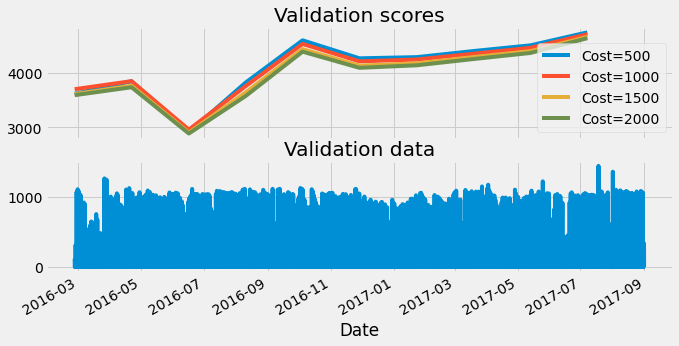

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
val_score_mean = val_score.rolling(10, min_periods=1).mean()
val_score_mean.plot(ax=axs[0])
axs[0].set(title='Validation scores')
# Plot the raw data
y_train[cv_index[0]:].plot(ax=axs[1])
axs[1].set(title='Validation data')


# Validation Model

Choose cost = 1000.

Train last 10% train data. 

Predict.

In [12]:
regression_model = SVR(kernel='rbf', C=1000)
regression_model.fit(X_train, y_train)
y_predict = regression_model.predict(X_test)

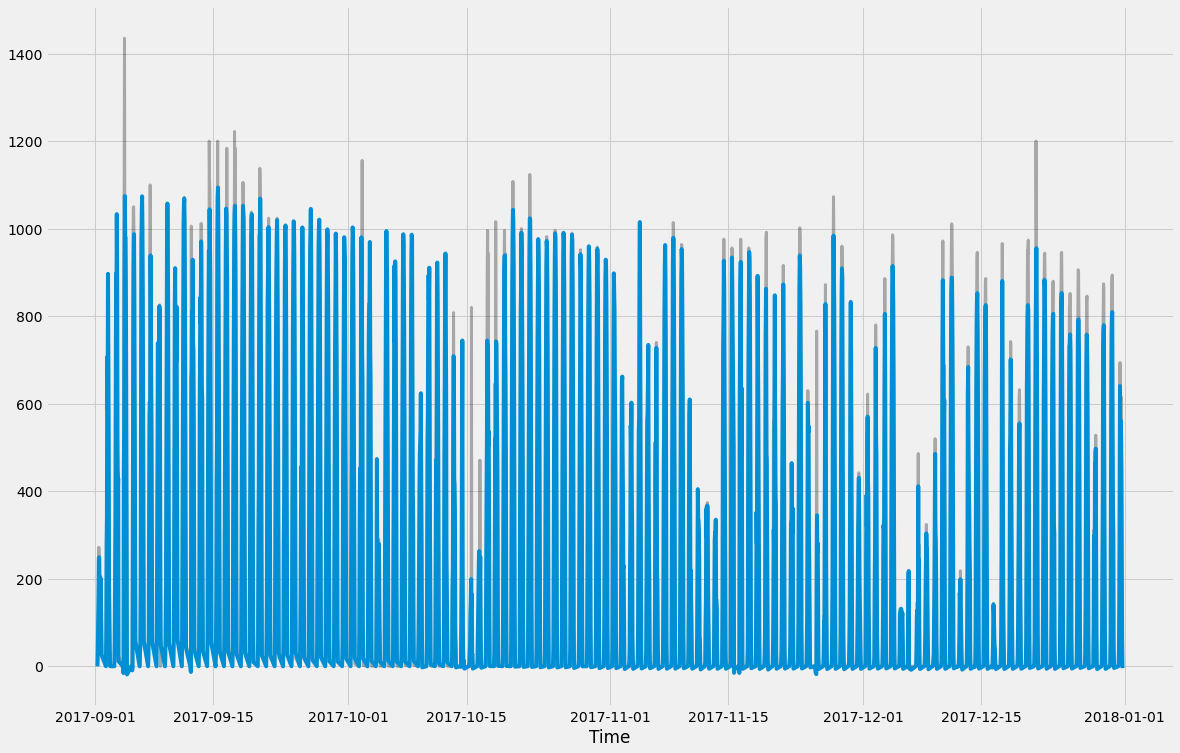

In [13]:
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, y_predict)
ax.set(xlabel="Time")
plt.show()


Model Score 

predict value : $ \hat{y}$  

actual value : $y$  

max of y : $y_{max}$

Mean squared error :

$$ \frac{1}{n} \sum_{k=1}^n ({y_{k} -\hat{y_{k}}})^2 $$

Mean absoluate error :

$$ \frac{1}{n} \sum_{k=1}^n \vert {y_{k} -\hat{y_{k}}} \vert $$

Mean relative error :

$$ \frac{100\%}{n} \sum_{k=1}^n \frac{{y_{k} -\hat{y_{k}}}}{y_{max}}  $$

Coefficient of determination :

$$ R^{2} \equiv 1 - \frac {SS_{res}}{SS_{tot}}$$

$$SS_{res} = \sum_{k=1}^n  { (\hat{y_{k}} - \tilde {y})^2}   ,SS_{tot} = \sum_{k=1}^n  { ({y_{k}} - \tilde {y})^2} 
, \tilde {y} = \frac{1}{n} \sum_{k=1}^n {y_{k}} $$

<!-- Mean absoluate percentage error :

% $$ \frac{100\%}{n} \sum_{k=1}^n \vert \frac{{y_{k} -\hat{y_{k}}}}{y_{k}} \vert $$ -->

In [14]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

def print_results(y_test, y_predict):
    print('Root mean squared error:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_predict))))
    print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test,y_predict)))
    print('Mean relative error:{:.2%}'.format(MRE(y_test,y_predict)))
    print('Coefficient of determination:{:.4f}'.format(r2_score(y_test,y_predict)))

print_results(y_test,y_predict)

Root mean squared error:90.5111
Mean absolute error:41.3922
Mean relative error:2.88%
Coefficient of determination:0.9338


# Look at Worst and Best Predicted Days

In [15]:
test_days = pd.DataFrame(y_test)
test_days['Predicted'] = y_predict 
test_days['error'] = test_days['power(KWH)'] - test_days['Predicted']
test_days['abs_error'] = test_days['error'].apply(np.abs)
test_days['year']=test_days.index.year
test_days['month']=test_days.index.month
test_days['day']=test_days.index.day

error_by_day = test_days.groupby(['year','month','day']).mean()[['power(KWH)','Predicted','error','abs_error']]

Looking worst predicted ten days.

In [16]:
def look_ten(data, Best=True):
    top_ten=data.sort_values('abs_error', ascending=Best).head(10)
    top_date = top_ten.index[0]
    top_date = str(top_date[0])+'-'+str(top_date[1])+'-'+str(top_date[2])
    print(top_ten)
    return top_date

# Worst absolute predicted days
Worst_date = look_ten(error_by_day, Best=False)

                power(KWH)   Predicted       error   abs_error
year month day                                                
2017 11    18   154.307692  333.052661 -178.744969  180.274448
     9     7    378.384615  417.860917  -39.476301  156.063582
           5    518.615385  374.755919  143.859465  154.031912
     11    19   406.923077  264.230074  142.693003  150.111951
     10    18   355.076923  369.233484  -14.156561  148.486383
           11   384.307692  412.836811  -28.529119  148.439382
     9     4    616.630936  511.049936  105.581000  144.719581
     11    20   347.538462  267.869715   79.668747  141.935474
     10    2    407.307692  453.849806  -46.542113  129.376060
           17   449.461538  374.230890   75.230648  118.362983


Looking best predicted ten days.

In [17]:
# Best predicted days
Best_date = look_ten(error_by_day, Best=True)

                power(KWH)   Predicted     error  abs_error
year month day                                             
2017 11    13   144.615385  144.803290 -0.187905   4.118103
     10    24   489.153846  487.960908  1.192938   4.486597
           23   495.538462  494.548015  0.990447   4.513733
           25   508.153846  509.595109 -1.441263   4.536935
     11    9    467.307692  466.689525  0.618167   5.022381
           11   157.000000  159.632324 -2.632324   5.140029
     12    16    42.000000   40.575692  1.424308   5.282515
     10    30   461.846154  464.148553 -2.302400   6.369657
     11    30   169.846154  165.877571  3.968583   6.909683
           4    388.153846  391.174022 -3.020176   7.267151


# Plotting  best/worst predicted days

Plotting worst predicted day.

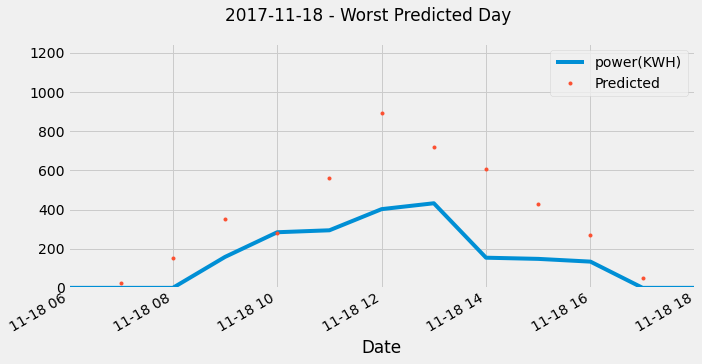

In [18]:
def plot_one(data, day, title):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(10)
    _ = data[['power(KWH)','Predicted']].plot(ax=ax, style=['-','.'])
    ax.set_ylim(0, 1250)
    ax.set_xbound(lower=day+' 06:00', upper=day +' 18:00')
    plot = plt.suptitle(day+ ' - ' + title +' Predicted Day ')

# plot worst day
plot_one(test_days, Worst_date, 'Worst')

Plotting best predicted day.

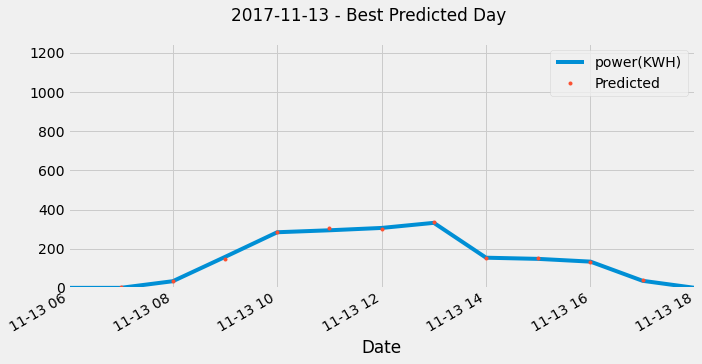

In [19]:
# plot best day
plot_one(test_days, Best_date, 'Best')